# Sarcasm detection

## ideas:
- автоматичне виявлення сарказму в соц мережах (твіттер etc)
- генерація саркастичних висловлювань 
- аналіз впливу емодзі пунктуація 
- сарказм у різних культурах порівняння 
- в політичних текстах
- в мультимодальному контексті (текст зображення голос)
- у новинах та заголовках
- 
- 

In [1]:
# imports section
import numpy as np
import math
from numpy import dot
from numpy.linalg import norm
from gensim import corpora, models, similarities
import string
import pandas as pd
import csv
import matplotlib.pyplot as plt

import gensim.downloader as api
from gensim.models import Word2Vec

import itertools

## Assign mood scores

In [2]:
lexicon = {
    "anxious": 0.1, "furious": 0.0, "peaceful": 0.9, "hate": 0.0, "joyful": 0.9, 
    "unacceptable": 0.1, "thrilled": 0.9, "infuriating": 0.1, "irate": 0.1, 
    "terrible": 0.1, "nervous": 0.2, "melancholy": 0.3, "depressed": 0.1, 
    "gloomy": 0.1, "serene": 0.8, "elated": 0.8, "ecstatic": 0.9, "overjoyed": 0.9,
    "gleeful": 0.7, "cheerful": 0.7, "optimistic": 0.7, "buoyant": 0.6, 
    "enthusiastic": 0.7, "upbeat": 0.6, "festive": 0.6, "playful": 0.6,
    "vivacious": 0.6, "amused": 0.7, "blissful": 0.6, "grateful": 0.8,
    "tranquil": 0.8, "relaxed": 0.7, "comfortable": 0.6, "cozy": 0.6,
    "warm": 0.6, "inviting": 0.6,  "satisfied": 0.5, "pleasant": 0.6, 
    "pleased" : 0.7, "happy": 0.8
    }

## Read adjectives from txt file and define array of given adjactive scores

In [3]:
corpus = api.load('glove-wiki-gigaword-100')

vector = corpus['computer']
print(vector)

[-1.6298e-01  3.0141e-01  5.7978e-01  6.6548e-02  4.5835e-01 -1.5329e-01
  4.3258e-01 -8.9215e-01  5.7747e-01  3.6375e-01  5.6524e-01 -5.6281e-01
  3.5659e-01 -3.6096e-01 -9.9662e-02  5.2753e-01  3.8839e-01  9.6185e-01
  1.8841e-01  3.0741e-01 -8.7842e-01 -3.2442e-01  1.1202e+00  7.5126e-02
  4.2661e-01 -6.0651e-01 -1.3893e-01  4.7862e-02 -4.5158e-01  9.3723e-02
  1.7463e-01  1.0962e+00 -1.0044e+00  6.3889e-02  3.8002e-01  2.1109e-01
 -6.6247e-01 -4.0736e-01  8.9442e-01 -6.0974e-01 -1.8577e-01 -1.9913e-01
 -6.9226e-01 -3.1806e-01 -7.8565e-01  2.3831e-01  1.2992e-01  8.7721e-02
  4.3205e-01 -2.2662e-01  3.1549e-01 -3.1748e-01 -2.4632e-03  1.6615e-01
  4.2358e-01 -1.8087e+00 -3.6699e-01  2.3949e-01  2.5458e+00  3.6111e-01
  3.9486e-02  4.8607e-01 -3.6974e-01  5.7282e-02 -4.9317e-01  2.2765e-01
  7.9966e-01  2.1428e-01  6.9811e-01  1.1262e+00 -1.3526e-01  7.1972e-01
 -9.9605e-04 -2.6842e-01 -8.3038e-01  2.1780e-01  3.4355e-01  3.7731e-01
 -4.0251e-01  3.3124e-01  1.2576e+00 -2.7196e-01 -8

In [4]:
data = ''

with open('../resources/sets/english-adjectives.txt', 'r') as file:
    data = file.read().replace('\n', ',')

adjectives = data.split(',')

adjectives_scored = {}

for adjective in adjectives:
    if adjective in corpus:
        adjectives_scored[adjective] = corpus[adjective]

## Extrapolate mood scores to adjactives using ML

In [42]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

lexicon_trained = {}

# Create a pipeline with StandardScaler and SVR, wrapped in MultiOutputRegressor
model = MultiOutputRegressor(make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0)))

x_train, y_train = [], []
for key in lexicon.keys():
    x_train.append(adjectives_scored[key])
    y_train.append([lexicon[key], 0])

x_train_np = np.array(x_train)
y_train_np = np.array(y_train)

    # Train the model
model.fit(x_train, y_train)

for key in adjectives_scored:
    result = model.predict([adjectives_scored[key]])
    lexicon_trained[key] = result[0][0]

# print(lexicon_trained)
for key, value in itertools.islice(lexicon_trained.items(), 20):
    print(key, ":", value)

abandoned : 0.42351808467904445
able : 0.4405493206909388
absolute : 0.4332413140883634
adorable : 0.5076165830819508
adventurous : 0.5151558501274796
academic : 0.4302687315900795
acceptable : 0.419529219889252
acclaimed : 0.4535211871790032
accomplished : 0.5353163085973955
accurate : 0.44732140216348526
aching : 0.4317435059677551
acidic : 0.4328384865312034
acrobatic : 0.4423616214136319
active : 0.4221623808893722
actual : 0.42308530562097285
adept : 0.46135904115824233
admirable : 0.5086799631563241
admired : 0.5098485489963382
adolescent : 0.416748111690608
adored : 0.5484287806950547


## Basic NLP techniques to extract mood score changes for text

In [43]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

def calculate_mood_series(text):
    lemmatizer = WordNetLemmatizer()
    # Tokenize text into words
    words = word_tokenize(text)
    # Apply lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    mood_series = []
    for word in lemmatized_words:
        if word in lexicon_trained.keys():
            mood_series.append(lexicon_trained[word])
    return mood_series

In [44]:
example_text = "It was the best of times, it was the worst of times, it was the age of wisdom, it was the age of foolishness, it was the epoch of belief, it was the epoch of incredulity, it was the season of light, it was the season of darkness, it was the spring of hope, it was the winter of despair."

print(calculate_mood_series(example_text))

[0.45973176454385156, 0.3325276673498717, 0.42756880944163317]


*may be try classification instead of regression? classify in positive and negative moods.*

## Classification   

In [5]:
lexicon = {
    "anxious": -1, "furious": -1, "peaceful": 1, "hate": -1, "joyful": 1, 
    "unacceptable": -1, "thrilled": 1, "infuriating": -1, "irate": -1, 
    "terrible": -1, "nervous": -1, "melancholy": -1, "useless": -1, "depressed": -1, 
    "gloomy": -1, "serene": 1, "elated": 1, "ecstatic": 1, "overjoyed": 1,
    "gleeful": 1, "cheerful": 1, "optimistic": 1, "buoyant": 1, "enthusiastic": 1,
    "upbeat": 1, "festive": 1, "playful": 1, "vivacious": 1, "amused": 1,
    "blissful": 1, "grateful": 1, "tranquil": 1, "relaxed": 1, "comfortable": 1,
    "cozy": 1, "warm": 1, "inviting": 1, "satisfied": 1, "pleasant": 1, 
    "pleased" : 1, "happy": 1
    }

In [6]:
data = ''

with open('../resources/sets/english-adjectives.txt', 'r') as file:
    data = file.read().replace('\n', ',')

adjectives = data.split(',')

adjectives_scored = {}

for adjective in adjectives:
    if adjective in corpus:
        adjectives_scored[adjective] = corpus[adjective]

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

lexicon_trained = {}

# Create a pipeline with StandardScaler and SVR, wrapped in MultiOutputRegressor
model = SVC(kernel='rbf', C=1.0, gamma='scale')

x_train, y_train = [], []
for key in lexicon.keys():
    x_train.append(adjectives_scored[key])
    y_train.append(lexicon[key])

x_train_prepared = x_train
y_train_prepared = np.array(list(lexicon.values()))

    # Train the model
model.fit(x_train_prepared, y_train_prepared)

for key in adjectives_scored:
    result = model.predict([adjectives_scored[key]])
    lexicon_trained[key] = result[0]

# print(lexicon_trained)
for key, value in itertools.islice(lexicon_trained.items(), 20):
    print(key, ":", value)

abandoned : 1
able : 1
absolute : 1
adorable : 1
adventurous : 1
academic : 1
acceptable : 1
acclaimed : 1
accomplished : 1
accurate : 1
aching : 1
acidic : 1
acrobatic : 1
active : 1
actual : 1
adept : 1
admirable : 1
admired : 1
adolescent : -1
adored : 1


## Analyse timeseries

## Let's try emojis/punctuation

In [8]:
import emoji

# def extract_emojis(s):
#   return ''.join(c for c in s if c in emoji.distinct_emoji_list('en'))

example_text = "Hey there! 👋 How's your day going? 🌞 Whether you're sipping coffee ☕, exploring new places 🌍, or just chilling at home �, I hope it's amazing! 🎉 Don't forget to smile 😄 and spread positivity! ✨ Life's a journey 🚀, so enjoy every moment! 🌈✨"
emoji_list = emoji.distinct_emoji_list(example_text)
print(emoji_list)

unicode_values = [emoji.demojize(e).encode('unicode_escape').decode('utf-8') for e in emoji_list]
print(unicode_values)

['🚀', '🌍', '🌈', '🌞', '☕', '👋', '🎉', '✨', '😄']
[':rocket:', ':globe_showing_Europe-Africa:', ':rainbow:', ':sun_with_face:', ':hot_beverage:', ':waving_hand:', ':party_popper:', ':sparkles:', ':grinning_face_with_smiling_eyes:']


Use two markers at the same time: text mood classifications (positive negative -> function) and emoji+punctuation 

**Before going further, we have to learn, which emojis happen the most often to be in sarcastic texts.**

dataset sarcasm_train2.csv, 

- tweet: The text of the tweet
- class: The respective class to which the tweet belongs. There are 4 classes: Irony, Sarcasm, Regular, Figurative (both irony and sarcasm)

['Be aware  dirty step to get money  #staylight #staywhite  #sarcastic #moralneeded @… https://t.co/Oj6BdyX3WG', "#sarcasm for #people who don't understand #diy #artattack http://t.co/rtyYmuDVUS", '@IminworkJeremy @medsingle #DailyMail readers being sensible as always #shocker #sarcastic #dailyfail #inHuntspocket #theyhatethenhs', '@wilw Why do I get the feeling you like games? #sarcasm', '-@TeacherArthurG @rweingarten You probably just missed the text. #sarcastic', "Tune in to Nigezie and be treated to Rachel Platten's Fight Song, move to MTV and get Reminisce &amp; Olamide's Local Rapper #Irony #TimesChange", 'What iz thiz?!?!? A friggin DC love fest??!?!? @andysignore @MurrellDan #Sarcasm #MovieFights', 'man, i wish i could sexually harass an intoxicated minor and NOT go to jail #sarcasm', "@raaachf for the car ride when I get to listen to you and jess the whole time? Yeah woo can't wait either. #sarcasm", "Aamir calls #BajrangiBhaijaan as Salman's best movie yet! You decide whether

C:\Users\vmelnyk2\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127996 (\N{EMOJI MODIFIER FITZPATRICK TYPE-3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vmelnyk2\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127995 (\N{EMOJI MODIFIER FITZPATRICK TYPE-1-2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vmelnyk2\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vmelnyk2\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128079 (\N{CLAPPING HANDS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vmelnyk2\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWa

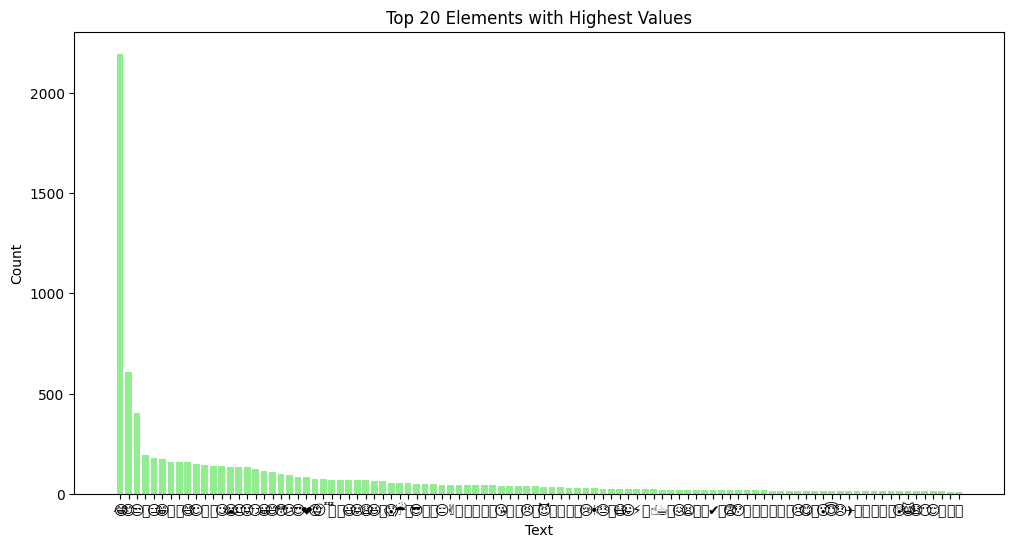

{'😂': 0.24243762419960257, '😊': 0.06712298520644734, '😒': 0.04449105762861559, '🏼': 0.021196732170457054, '😑': 0.019761536763082357, '😁': 0.018988739236034443, '🏻': 0.01733274453521749, '👍': 0.017222344888496357, '😅': 0.017222344888496357, '☺': 0.016449547361448442, '👏': 0.015897549127842792, '👌': 0.015345550894237139, '😉': 0.015014351954073748, '😭': 0.014793552660631487, '😐': 0.014572753367189224, '😜': 0.014462353720468094, '😏': 0.01335835725325679, '😀': 0.012364760432766615, '😄': 0.012033561492603224, '😳': 0.010819165378670788, '😕': 0.010156767498344006, '😍': 0.00927357032457496, '❤': 0.00894237138441157, '😡': 0.007948774563921396, '😴': 0.007948774563921396, '🙌': 0.0077279752704791345, '🏽': 0.007617575623758004, '😃': 0.007396776330315743, '😝': 0.007396776330315743, '😩': 0.007286376683594612, '😆': 0.007175977036873482, '🙈': 0.007065577390152351, '😱': 0.005961580922941047, '☔': 0.005851181276219916, '👀': 0.005740781629498786, '😎': 0.005519982336056524, '🔥': 0.005409582689335394, '💔': 0

In [10]:
values_second_column = {"sarcasm", "irony", "figurative"}
filtered_values = []

with open("../resources/sarcasm_train2.csv", newline="", encoding="utf8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if row and row[1] in values_second_column: 
            filtered_values.append(row[0])

print(filtered_values[:20])

emoji_count = {}
total_emoji = 0

for text in filtered_values:
    for char in text:
        if char in emoji.EMOJI_DATA:
            total_emoji += 1
            if char not in emoji_count.keys():
                emoji_count[char] = 1
            else:
                emoji_count[char] += 1

print(emoji_count)

# sort by value and take 20 most important emojis
top_emoji = dict(sorted(emoji_count.items(), key=lambda item: item[1], reverse=True)[:100])

labels = list(top_emoji.keys())
values = list(top_emoji.values())

plt.figure(figsize=(12, 6))
plt.bar(labels, values, color='lightgreen')
plt.ylabel("Count")
plt.xlabel("Text")
plt.title("Top 20 Elements with Highest Values")
plt.show()

top_emoji_normalized = {}
for elem in top_emoji:
    top_emoji_normalized[elem] = top_emoji[elem] / total_emoji

print(top_emoji_normalized)

Since emojis follow logarithmic power low, we will scale them: 
$$ e_{scaled} = \lfloor \ln e_{score} \rfloor$$

In [22]:
# emojis follow power law:
import math

a = 2.7
top_emoji_scaled = {}
for item in top_emoji:
    top_emoji_scaled[item] = math.floor( math.log( top_emoji[item], a))

print(top_emoji_scaled)

{'😂': 7, '😊': 6, '😒': 6, '🏼': 5, '😑': 5, '😁': 5, '🏻': 5, '👍': 5, '😅': 5, '☺': 5, '👏': 5, '👌': 4, '😉': 4, '😭': 4, '😐': 4, '😜': 4, '😏': 4, '😀': 4, '😄': 4, '😳': 4, '😕': 4, '😍': 4, '❤': 4, '😡': 4, '😴': 4, '🙌': 4, '🏽': 4, '😃': 4, '😝': 4, '😩': 4, '😆': 4, '🙈': 4, '😱': 4, '☔': 3, '👀': 3, '😎': 3, '🔥': 3, '💔': 3, '😔': 3, '✌': 3, '🎉': 3, '💁': 3, '🔫': 3, '👎': 3, '🎂': 3, '😘': 3, '👊': 3, '💜': 3, '😠': 3, '🎶': 3, '😈': 3, '😬': 3, '🙏': 3, '💩': 3, '🏾': 3, '😢': 3, '☀': 3, '😓': 3, '💀': 3, '😷': 3, '😛': 3, '⚡': 3, '🙊': 3, '☝': 3, '☕': 3, '✋': 3, '😖': 2, '😫': 2, '💦': 2, '😤': 2, '✔': 2, '💃': 2, '😨': 2, '😯': 2, '🏿': 2, '💨': 2, '👋': 2, '🍷': 2, '👻': 2, '💋': 2, '😣': 2, '😋': 2, '💯': 2, '😮': 2, '😇': 2, '😞': 2, '✈': 2, '✊': 2, '💙': 2, '🏈': 2, '💖': 2, '💪': 2, '😲': 2, '😹': 2, '😧': 2, '😶': 2, '😌': 2, '💚': 2, '⭐': 2, '👈': 2}


**Track mood score:**

In [23]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

def calculate_series(text):
    mood_points = {}
    emoji_points = {}

    lemmatizer = WordNetLemmatizer()
    # Tokenize text into words
    words = word_tokenize(text)

    # Apply lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word.lower()) for word in words]

    # mood_series = []
    for position, word in enumerate(lemmatized_words):
        if word in lexicon_trained.keys():
            mood_points[position] = lexicon_trained[word]
            # mood_series.append(lexicon_trained[word])
        if word in top_emoji_scaled.keys():
            emoji_points[position] = top_emoji_scaled[word]
    return len(lemmatized_words), mood_points, emoji_points

# example_text = "It was the best of times, it was the worst of times, it was the age of wisdom, it was the age of foolishness, it was the epoch of belief, it was the epoch of incredulity, it was the season of light, it was the season of darkness, it was the spring of hope, it was the winter of despair."
# print(calculate_mood_series(example_text))

emoji_text = "It was the best of times 🎉, it was the worst of times 😞, it was the age of wisdom 🧠, it was the age of foolishness 🤪, it was the epoch of belief 🙏, it was the epoch of incredulity 🤨, it was the season of light ☀️, it was the season of darkness 🌑, it was the spring of hope 🌱, it was the winter of despair ❄️."
print(calculate_series(emoji_text))


# example of sarcastic texts:
sarcastic_texts = ["School for 12 years, college for 4 years... then your work untill you die lonely. Great 😒."]
print(calculate_series(sarcastic_texts[0]))

# returns nothing: have to extend dataset of words!

(80, {3: 1, 11: -1, 53: 1}, {6: 3, 14: 2, 38: 3})
(21, {16: -1, 18: 1}, {19: 6})


mood(x), emoj(x)

$$f_{e}(x) = \max\limits_{x^{*}\in U_{x}}|emoj(x^{*}) - emoj(x)|$$

\begin{equation}
  f_m(x)=\begin{cases}
    1, & \text{if $\max\limits_{x^{*}\in U_{x}}|mood(x^{*}) - mood(x)| = 2$}.\\
    0, & \text{otherwise}.
  \end{cases}
\end{equation}

$FLRS(f_{m}, f_{e}) -> f(x)$

In [31]:
sarcastic_texts = ["School for 12 years, college for 4 years... then your work untill you die lonely. Great 😒."]
print(calculate_series(sarcastic_texts[0]))
n, moods, emojis = calculate_series(sarcastic_texts[0])

for i in range(n):
    if i not in moods.keys():
        moods[i] = 0
    if i not in emojis.keys():
        emojis[i] = 0

window = 10 # magic number 
f_moods, f_emojis = [], []
for i in range(n):
    cutoff_point_lower = max(i - window, 0)
    cutoff_point_upper = min(i + window, n - 1)
    list_of_mood_variations = [0]
    for j in range(cutoff_point_lower, i, 1):
        list_of_mood_variations.append(abs(moods[j] - moods[i]))
    if max(list_of_mood_variations) == 2:
        f_moods.append(1)
    else:
        f_moods.append(0)
    list_of_emoji_scores = [0]
    for j in range(cutoff_point_lower, cutoff_point_upper, 1):
        list_of_emoji_scores.append(emojis[j])
    f_emojis.append(max(list_of_emoji_scores))

print(f_moods)
print(f_emojis)

multiplied = (np.array(f_moods) * np.array(f_emojis)) 
if max(f_emojis) != 0:
    multiplied = multiplied // max(f_emojis)
print(multiplied)

if 1 in multiplied:
    print("Tenative sarcasm detection at: ", np.where(multiplied == 1)[0])
else:
    print("No detection")

(21, {16: -1, 18: 1}, {19: 6})
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
Tenative sarcasm detection at:  [18]


TODO:
- make bigger word base, not just adjectives
- f_m, f_e functions define and code in
- define resulting function (may be try FL)
